## Code Modules

In [1]:
import warnings; warnings.filterwarnings('ignore')
import os,time,numpy as np,pylab as pl
from keras.preprocessing import image as kimage
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier
from sklearn.metrics import \
accuracy_score,classification_report
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from PIL import ImageFile

## Data Loading

In [2]:
def path_to_tensor(img_path,fpath,img_size):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(img_size,img_size))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath,img_size):
    tensor_list=[path_to_tensor(img_path,fpath,img_size) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

In [3]:
fpath='../input/horse-breeds/'
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron']
flist=sorted(os.listdir(fpath))
img_size=64
y=np.array([int(el[:2]) for el in flist],
           dtype='int8')-1
X=np.array(paths_to_tensor(flist,fpath,img_size),
           dtype='float32')/255
X=X.reshape(-1,3*img_size**2)
N=y.shape[0]; shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
X,y=X[shuffle_ids],y[shuffle_ids]
X_train,X_test,y_train,y_test=\
train_test_split(X,y,test_size=.3,
                 random_state=1,stratify=y)

100%|██████████| 139/139 [00:00<00:00, 143.46it/s]


Label:  3 Vladimir Heavy Draft


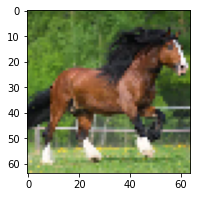

In [4]:
n=np.random.randint(5)
print('Label: ',y_test[n],
      names[y_test[n]])
pl.figure(figsize=(3,3))
pl.imshow((X_test\
.reshape(-1,img_size,img_size,3)[n]));

## Classifiers

In [5]:
lr=LogisticRegression(C=100.0,random_state=1,
                      solver='lbfgs',multi_class='ovr')
lr.fit(X_train,y_train)
y_test_lr=lr.predict(X_test)
print('Misclassified examples: %d'%(y_test!=y_test_lr).sum())
print('Accuracy: %.3f'%accuracy_score(y_test,y_test_lr))
print("Classification Report:\n%s\n"%\
      (classification_report(y_test,y_test_lr)))

Misclassified examples: 24
Accuracy: 0.429
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.30      0.38      0.33         8
           2       0.36      0.50      0.42         8
           3       0.71      0.56      0.63         9
           4       0.38      0.33      0.35         9

    accuracy                           0.43        42
   macro avg       0.45      0.43      0.43        42
weighted avg       0.46      0.43      0.43        42




In [6]:
def plot_decision_regions(X,y,classifier,
                          test_ids=None,resolution=.05):
    markers=('s','o','^','v','x')
    colors=('red','blue','green','purple','cyan')
    X=scale(X)
    X=PCA(n_components=2).fit_transform(X)
    cmap=ListedColormap(colors[:len(np.unique(y))])
    x1_min,x1_max=X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),
                        np.arange(x2_min,x2_max,resolution))
    classifier.fit(X,y)
    Z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z=Z.reshape(xx1.shape)
    pl.figure(figsize=(10,10))
    pl.contourf(xx1,xx2,Z,alpha=.3,cmap=cmap)
    pl.xlim(xx1.min(),xx1.max())
    pl.ylim(xx2.min(),xx2.max())
    for ids,cl in enumerate(np.unique(y)):
        pl.scatter(x=X[y==cl,0],y=X[y==cl,1],
                   alpha=.8,c=colors[ids],
                   marker=markers[ids], 
                   label=cl,edgecolor='black')
    if test_ids:
        X_test,y_test=X[test_ids,:],y[test_ids]
        pl.scatter(X_test[:,0],X_test[:,1],
                   c='',edgecolor='black',
                   alpha=1.,linewidth=1,marker='o',
                   s=100,label='test set')

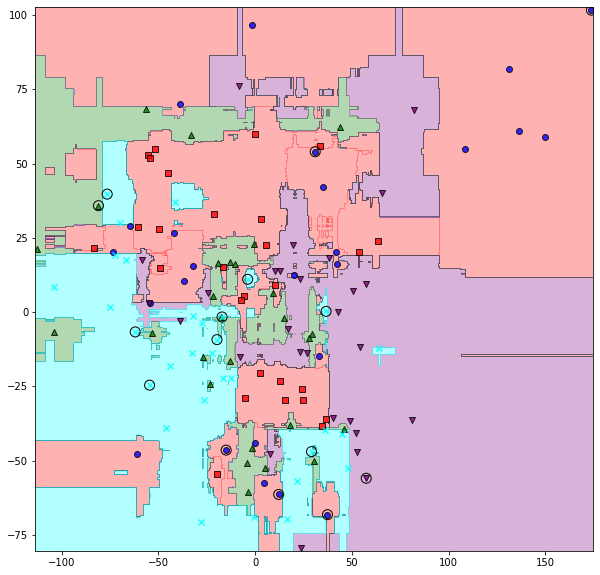

In [7]:
rf=RandomForestClassifier()
plot_decision_regions(X,y,classifier=rf,
                      test_ids=range(1,16))

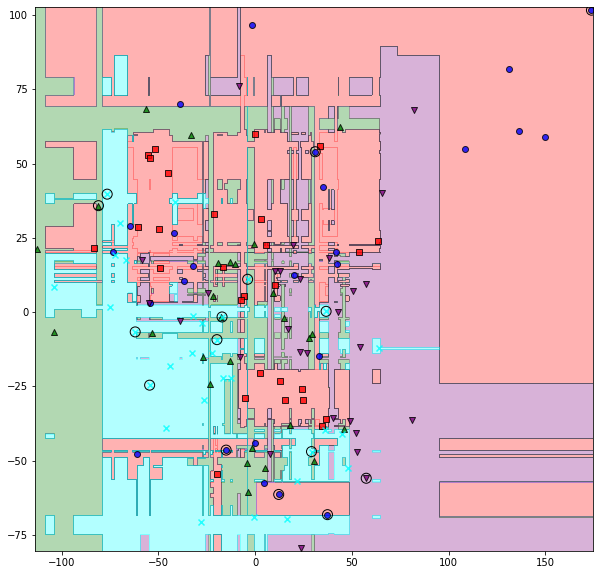

In [8]:
gb=GradientBoostingClassifier()
plot_decision_regions(X,y,classifier=gb,
                      test_ids=range(1,16))

In [9]:
clf=MLPClassifier(hidden_layer_sizes=(2048,),max_iter=120,solver='adam',
                  verbose=1,random_state=1,learning_rate_init=.0001,
                  n_iter_no_change=50)
clf.fit(X_train,y_train)

Iteration 1, loss = 1.81194657
Iteration 2, loss = 9.45574155
Iteration 3, loss = 4.42445103
Iteration 4, loss = 4.62186164
Iteration 5, loss = 2.32374291
Iteration 6, loss = 3.08038736
Iteration 7, loss = 2.80658869
Iteration 8, loss = 1.92205534
Iteration 9, loss = 1.71864348
Iteration 10, loss = 1.40329722
Iteration 11, loss = 1.58627945
Iteration 12, loss = 1.56241329
Iteration 13, loss = 1.42500313
Iteration 14, loss = 1.01219259
Iteration 15, loss = 1.04856711
Iteration 16, loss = 1.21439735
Iteration 17, loss = 1.24338740
Iteration 18, loss = 1.09904902
Iteration 19, loss = 0.88499276
Iteration 20, loss = 0.78634816
Iteration 21, loss = 0.82545924
Iteration 22, loss = 0.89006995
Iteration 23, loss = 0.82658094
Iteration 24, loss = 0.71168112
Iteration 25, loss = 0.67854006
Iteration 26, loss = 0.67051408
Iteration 27, loss = 0.67687810
Iteration 28, loss = 0.66552049
Iteration 29, loss = 0.59597741
Iteration 30, loss = 0.53858720
Iteration 31, loss = 0.53975363
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(2048,), learning_rate_init=0.0001,
              max_iter=120, n_iter_no_change=50, random_state=1, verbose=1)

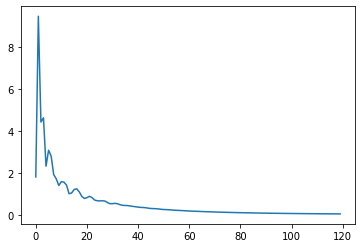

In [10]:
pl.plot(clf.loss_curve_);

0.40476190476190477


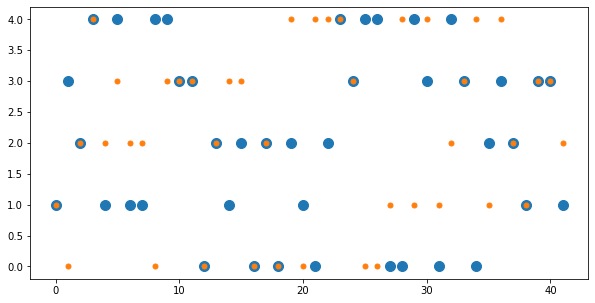

In [11]:
print(clf.score(X_test,y_test))
y_test_mlp=clf.predict(X_test)
pl.figure(figsize=(10,5))
pl.scatter(range(y_test.shape[0]),y_test,s=100)
pl.scatter(range(y_test.shape[0]),y_test_mlp,s=25);